<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/dataIncodingTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        files = os.listdir(category_dir)
        print(f'Loading {len(files)} files from category: {category} in {split} set')  # 각 카테고리에서 로드한 파일 수 출력
        for file in files:
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 각 데이터셋의 크기 확인
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 각 데이터셋의 클래스별 데이터 수 확인
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    print(f'Class distribution in {dataset_name}: {dict(zip(unique, counts))}')

print_class_distribution(y_train, 'y_train')
print_class_distribution(y_val, 'y_val')
print_class_distribution(y_test, 'y_test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 인코딩된 클래스 확인
print(f'Classes found by LabelEncoder: {label_encoder.classes_}')

# 원-핫 인코딩
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded)

Loading 3500 files from category: normal in train set
Loading 1168 files from category: fault_BB in train set
Loading 1168 files from category: fault_RI in train set
Loading 1168 files from category: fault_SM in train set
Loading 750 files from category: normal in validation set
Loading 176 files from category: fault_BB in validation set
Loading 176 files from category: fault_RI in validation set
Loading 176 files from category: fault_SM in validation set
Loading 750 files from category: normal in test set
Loading 176 files from category: fault_BB in test set
Loading 176 files from category: fault_RI in test set
Loading 176 files from category: fault_SM in test set
X_train shape: (7004, 12001, 2), y_train shape: (7004,)
X_val shape: (1278, 12001, 2), y_val shape: (1278,)
X_test shape: (1278, 12001, 2), y_test shape: (1278,)
Class distribution in y_train: {'fault_BB': 1168, 'fault_RI': 1168, 'fault_SM': 1168, 'normal': 3500}
Class distribution in y_val: {'fault_BB': 176, 'fault_RI': 176

In [6]:
# 모델 정의
model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=16, strides=16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.MaxPooling1D(pool_size=2, strides=2),
    layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu'),
    layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu'),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, activation='relu'),
    layers.MaxPooling1D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(units=5000, activation='relu'),
    layers.Dense(units=1000, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 모델 훈련
history = model.fit(X_train, y_train_categorical, epochs=2, validation_data=(X_val, y_val_categorical), batch_size=32)

Epoch 1/2
219/219 [==============================] - 111s 499ms/step - loss: 1.2111 - accuracy: 0.5154 - val_loss: 0.6956 - val_accuracy: 0.7246
Epoch 2/2
219/219 [==============================] - 111s 505ms/step - loss: 0.3462 - accuracy: 0.8629 - val_loss: 0.1141 - val_accuracy: 0.9679


In [8]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')

40/40 [==============================] - 2s 44ms/step - loss: 0.1314 - accuracy: 0.9523
Test accuracy: 0.9522691965103149


In [9]:
# 혼동행렬 및 평가 지표 계산
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test_encoded

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

40/40 [==============================] - 2s 40ms/step
Confusion Matrix:
[[135   0   1  40]
 [  0 176   0   0]
 [ 20   0 156   0]
 [  0   0   0 750]]

Classification Report:
              precision    recall  f1-score   support

      normal       0.87      0.77      0.82       176
    fault_BB       1.00      1.00      1.00       176
    fault_RI       0.99      0.89      0.94       176
    fault_SM       0.95      1.00      0.97       750

    accuracy                           0.95      1278
   macro avg       0.95      0.91      0.93      1278
weighted avg       0.95      0.95      0.95      1278



In [10]:
# F1 스코어, Precision, Recall 계산
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Weighted F1-score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

Weighted F1-score: 0.9507
Weighted Precision: 0.9516
Weighted Recall: 0.9523


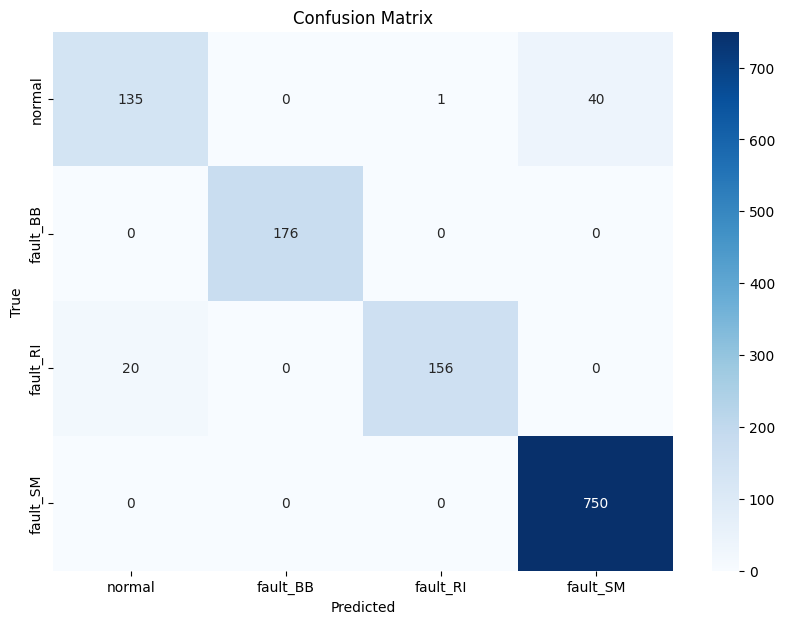

In [11]:
# 혼동행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# 평가 전에 테스트 데이터셋의 클래스 분포를 출력합니다.
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)
print(f"Class distribution in original y_test: {dict(zip(unique_test, counts_test))}")

# 모델이 예측한 결과의 클래스 분포를 확인합니다.
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print(f"Class distribution in predicted y_pred: {dict(zip(unique_pred, counts_pred))}")

# 모델의 예측과 실제 레이블을 비교하여 어디에서 문제가 발생했는지 확인합니다.
for true_label, pred_label in zip(y_true, y_pred):
    if true_label != pred_label:
        print(f"True: {true_label}, Predicted: {pred_label}")

Class distribution in original y_test: {0: 176, 1: 176, 2: 176, 3: 750}
Class distribution in predicted y_pred: {0: 155, 1: 176, 2: 157, 3: 790}
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 2
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted:

In [13]:
# LabelEncoder가 각 클래스 이름을 어떻게 숫자로 변환했는지 확인
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(class_mapping)

{0: 'fault_BB', 1: 'fault_RI', 2: 'fault_SM', 3: 'normal'}


In [14]:
from sklearn.metrics import confusion_matrix

# 예측값과 실제값을 다시 확인
print(f"True labels: {y_true}")
print(f"Predicted labels: {y_pred}")

# 혼동 행렬 재생성
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

True labels: [3 3 3 ... 2 2 2]
Predicted labels: [3 3 3 ... 2 2 2]
Confusion Matrix:
[[135   0   1  40]
 [  0 176   0   0]
 [ 20   0 156   0]
 [  0   0   0 750]]


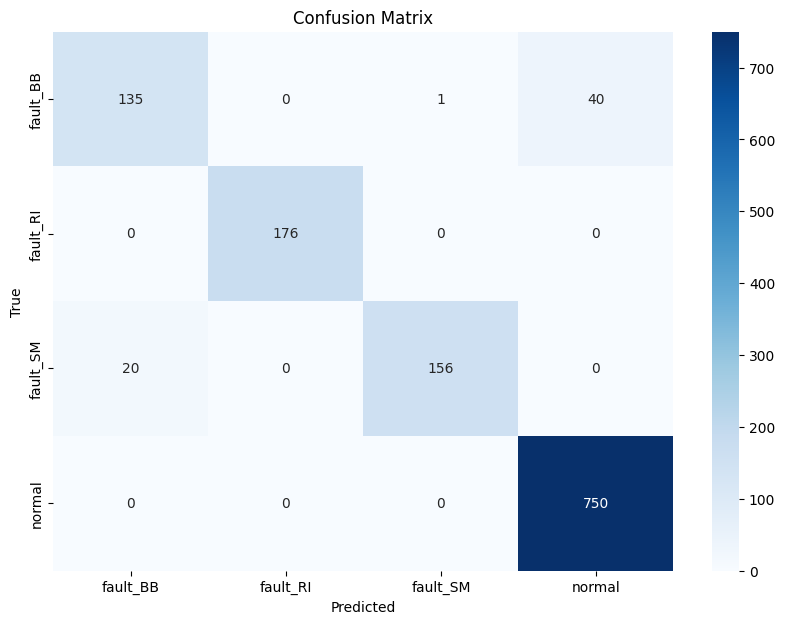

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# 평가 전에 테스트 데이터셋의 클래스 분포를 출력합니다.
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)
print(f"Class distribution in original y_test: {dict(zip(unique_test, counts_test))}")

# 모델이 예측한 결과의 클래스 분포를 확인합니다.
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print(f"Class distribution in predicted y_pred: {dict(zip(unique_pred, counts_pred))}")

# 모델의 예측과 실제 레이블을 비교하여 어디에서 문제가 발생했는지 확인합니다.
for true_label, pred_label in zip(y_true, y_pred):
    if true_label != pred_label:
        print(f"True: {true_label}, Predicted: {pred_label}")

Class distribution in original y_test: {0: 176, 1: 176, 2: 176, 3: 750}
Class distribution in predicted y_pred: {0: 155, 1: 176, 2: 157, 3: 790}
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 2
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted: 3
True: 0, Predicted:

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true=y_test_encoded, y_pred=y_pred)
print(conf_matrix)

40/40 [==============================] - 2s 40ms/step
[[135   0   1  40]
 [  0 176   0   0]
 [ 20   0 156   0]
 [  0   0   0 750]]
